In [1]:
from pathlib import Path
import warnings
from pyciss import io
import seaborn as sns
from sklearn.preprocessing import scale
sns.set_style('white')
sns.set_context('notebook')
%matplotlib nbagg

In [2]:
root = Path('/Users/klay6683/Dropbox/data/ciss/SOI')

In [3]:
fpaths = list(root.glob('*2.map.dst.cal.cub'))

In [4]:
def remove_mean_value(data, axis=1):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        mean_value = np.nanmean(data, axis=axis)
    subtracted = data - mean_value[:, np.newaxis]
    return subtracted

In [5]:
savedir = fpaths[0].parent / 'std_overlays'
savedir.mkdir(exist_ok=True)

In [6]:
%matplotlib nbagg
sns.set_style('white')

In [7]:
for i,fpath in enumerate(fpaths):
    print(i, fpath.name)

0 N1467345444_2.map.dst.cal.cub
1 N1467345503_2.map.dst.cal.cub
2 N1467345621_2.map.dst.cal.cub
3 N1467345680_2.map.dst.cal.cub
4 N1467345739_2.map.dst.cal.cub
5 N1467345798_2.map.dst.cal.cub
6 N1467345857_2.map.dst.cal.cub
7 N1467345916_2.map.dst.cal.cub
8 N1467345975_2.map.dst.cal.cub
9 N1467346034_2.map.dst.cal.cub
10 N1467346093_2.map.dst.cal.cub
11 N1467346152_2.map.dst.cal.cub
12 N1467346211_2.map.dst.cal.cub
13 N1467346270_2.map.dst.cal.cub
14 N1467346329_2.map.dst.cal.cub
15 N1467346388_2.map.dst.cal.cub
16 N1467346447_2.map.dst.cal.cub
17 N1467346506_2.map.dst.cal.cub
18 N1467346565_2.map.dst.cal.cub
19 N1467346624_2.map.dst.cal.cub
20 N1467347210_2.map.dst.cal.cub
21 N1467347249_2.map.dst.cal.cub
22 N1467347445_2.map.dst.cal.cub
23 N1467347504_2.map.dst.cal.cub


In [8]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    med = np.nanmedian(arr, axis=1)
    return np.nanmedian(np.abs(arr - med[:, np.newaxis]), axis=1)

<IPython.core.display.Javascript object>


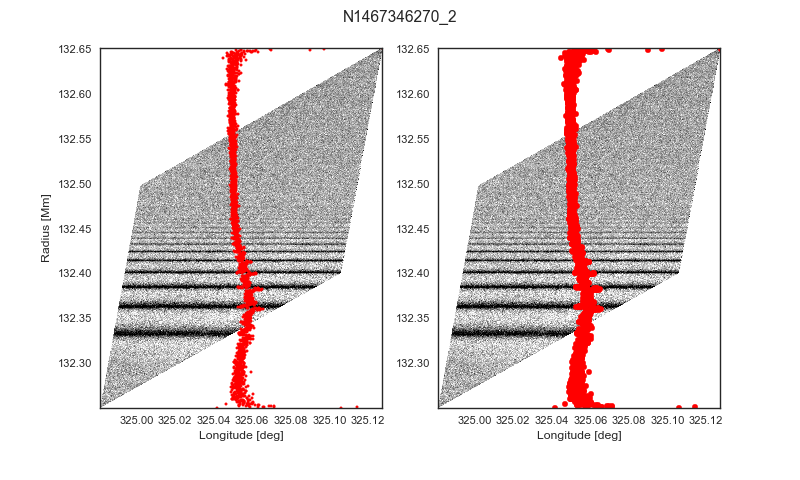

In [9]:
for fpath in fpaths[13:14]:
    cube = io.RingCube(str(fpath))
    img = cube.data[0]
    low, high = np.percentile(img[img>0], (2,98))
    img[img<0] = np.nan
    sub = remove_mean_value(img)
    sublow, subhigh = np.percentile(sub[~np.isnan(sub)], (2,98))
    fig, ax = plt.subplots(ncols=2, figsize=(10, 6), sharey=False)
#     ax = ax.ravel()
#     ax=[ax]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        stats = mad(img)
    notnan_ind = ~np.isnan(stats)
    # scale the stats so that I can shift it easily to middle of image
    X = scale(stats[notnan_ind], with_mean=True, with_std=False)
    # shift image to middle of azimuth extent (the first 2 items of cube.extent)
    X = X*5 + np.mean(cube.extent[:2])
    # create Y array out of the radial extent
    Y = np.linspace(cube.extent[2],
                    cube.extent[3],
                    cube.img.shape[0])
    # filter for not-NANs
    Y = Y[notnan_ind]
    scattersize = 5
    for i, axis in enumerate(ax):
        cube.imshow(ax=axis, set_extent=True)
        if i == 1:
            scattersize = 25
        axis.scatter(X, Y, s=scattersize, color='red')
        axis.set_xlim(cube.extent[0], cube.extent[1])
        axis.set_ylim(cube.extent[2], cube.extent[3])
        axis.set_title('')
        if i==1:
            axis.set_ylabel('')
#     ax[2].plot(np.nanstd(img, axis=1))
    fig.subplots_adjust(bottom=0.15)
    fig.suptitle(fpath.name.split('.')[0],fontsize=14)
    fig.savefig(str(savedir / (fpath.name[:-4]+'.png')), dpi=150)
#     plt.close(fig)

<IPython.core.display.Javascript object>


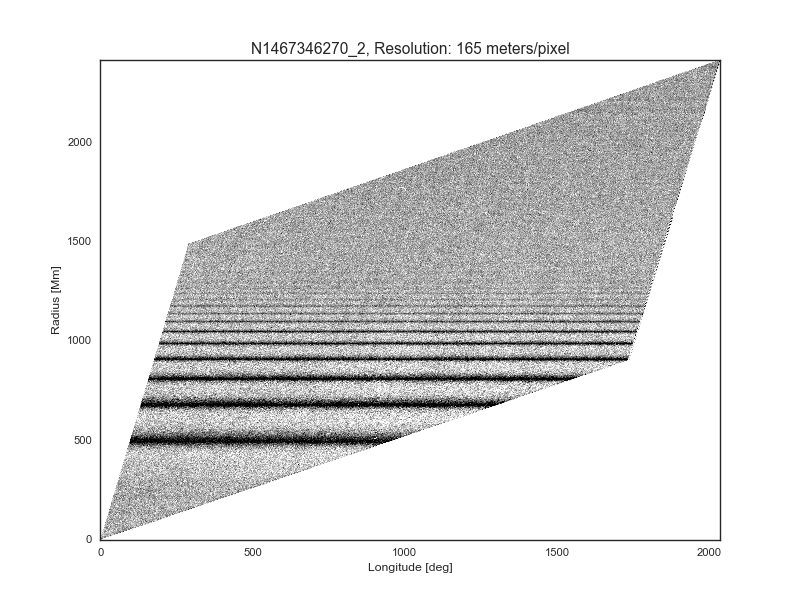

In [10]:
cube.imshow(set_extent=False)

<IPython.core.display.Javascript object>


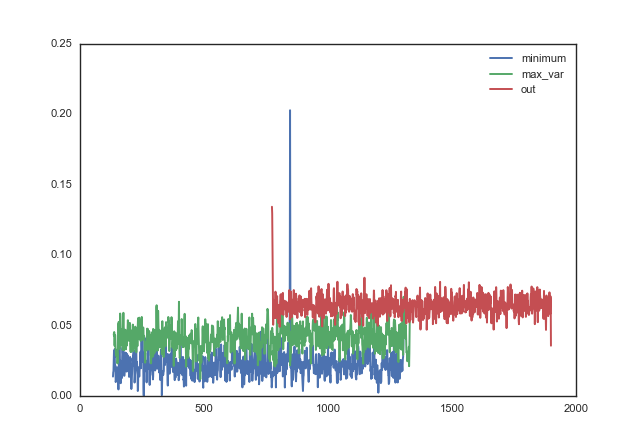

In [11]:
plt.figure()
min_ind = 681
max_var_ind = 694
out_ind = 1747
plt.plot(img[min_ind], label='minimum')
plt.plot(img[max_var_ind], label='max_var')
plt.plot(img[out_ind], label='out')
plt.legend(loc=1)

In [12]:
import wavelets
from wavelets import WaveletAnalysis

In [13]:
x1 = img[max_var_ind]
x1 = x1[~np.isnan(x1)]
x2 = img[min_ind]
x2 = x2[~np.isnan(x2)]

In [14]:
cube.resolution_val

165.82982458783

In [15]:
# dt = 0.35

def do_wavelet(x):
    dt = 1
    wa = WaveletAnalysis(x, dt=dt)
    power = wa.wavelet_power
    scales = wa.scales
    t = wa.time
    T, S = np.meshgrid(t, scales)
    return T, S, power, t

def plot_wavelet(x1, x2):
    T, S, power, t = do_wavelet(x1)
    print(power.max())
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(4.5,6))
    im = ax[0].contourf(T, S, power*1000, 100, cmap='viridis', vmax=1.5)
    plt.colorbar(im, ax=ax[0])
    T, S, power, t = do_wavelet(x2)
    print(power.max())
    im2 = ax[1].contourf(T, S, power*1000, 100, cmap='viridis', vmax=1.5)
    plt.colorbar(im2, ax=ax[1])
    for axis in ax:
        axis.set_yscale('log')
        axis.set_ylabel("Arbitrary power in 1/distance")
    ax[0].set_title("Maximum dispersion row")
    ax[1].set_title("Minimum dispersion row")
    ax[1].set_xlabel("Along Azimuth [pixel]")
    

0.00158278883085


<IPython.core.display.Javascript object>


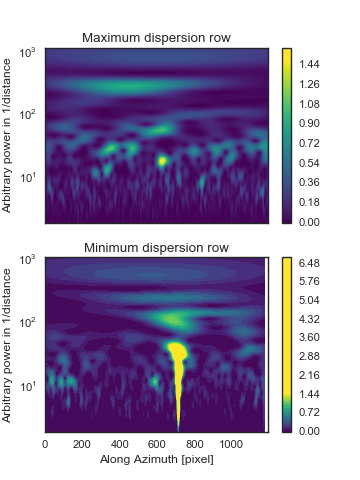

0.00664618132116


In [16]:
plot_wavelet(x1, x2)

# Sinusoidal fits

In [17]:
img = cube.img

In [18]:
img.shape

(2418, 2035)

In [56]:
import numpy as np
from scipy.optimize import curve_fit

# create the function we want to fit
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

def fit_row(data, guess_freq):
    guess_amplitude = 2*np.std(data)
    guess_phase = 0
    guess_offset = np.mean(data)

    p0=[guess_freq, guess_amplitude,
        guess_phase, guess_offset]

    t = np.arange(len(data))
    # now do the fit
    fit = curve_fit(my_sin, t, data, p0=p0)

    # we'll use this to plot our first estimate. This might already be good enough for you
    data_first_guess = my_sin(t, *p0)

    # recreate the fitted curve using the optimized parameters
    data_fit = my_sin(t, *fit[0])

    plt.figure()
    plt.plot(data, '.')
    plt.plot(data_fit, label='after fitting')
    plt.plot(data_first_guess, label='first guess')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


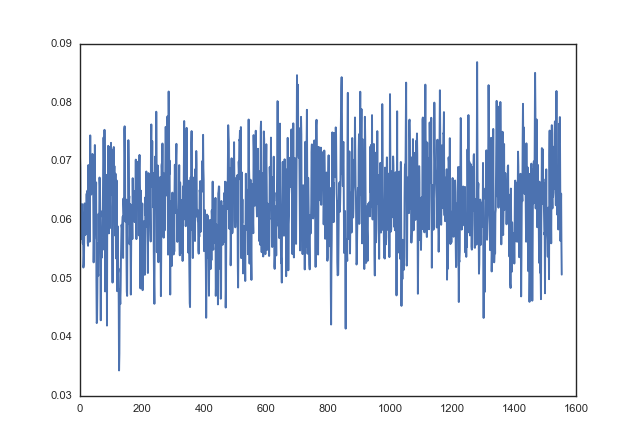

In [57]:
row = img[1000:1001]
data = row[~np.isnan(row)][:-3]
plt.figure()
plt.plot(data)

<IPython.core.display.Javascript object>


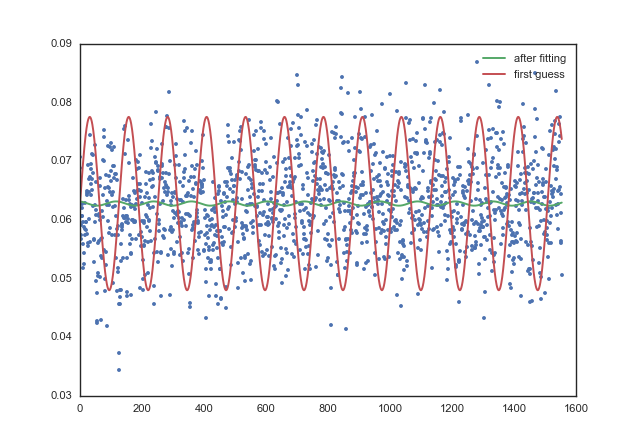

In [59]:
fit_row(data, 0.05)